# Exploratory Data Analysis - MIMIC-IV Dataset in PostgreSQL

The notebook has been implemented using Python 3.10.11.  
The MIMIC-IV v2.2 dataset has been loaded into PostgreSQL server running PostgreSQL 15.2 (Ubuntu 15.2-1.pgdg22.04+1).  
We suggest creating a virtual environment for this notebook.  
You need to install the following packages to run this notebook:

| Package Name | License                                                                                                                 | Documentation                           |
|--------------|-------------------------------------------------------------------------------------------------------------------------|-----------------------------------------|
| psycopg2     | [![License: LGPL v3](https://img.shields.io/badge/License-LGPL_v3-blue.svg)](https://www.gnu.org/licenses/lgpl-3.0)     | [Docs](https://www.psycopg.org/)        |
| pandas       | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://pandas.pydata.org/)      |
| numpy        | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://numpy.org/)              |
| seaborn      | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://seaborn.pydata.org/)     |
| scipy        | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://scipy.org/)              |
| tomli        | [![License: MIT](https://img.shields.io/badge/License-MIT-blue.svg)](https://opensource.org/licenses/MIT)               | [Docs](https://github.com/hukkin/tomli) |
| tqdm         | [![License](https://img.shields.io/pypi/l/tqdm.svg)](https://github.com/tqdm/tqdm/blob/master/LICENCE)                  | [Docs](https://tqdm.github.io/)         |
| matplotlib   | [(BSD-compatible, PSF-based)](https://matplotlib.org/stable/users/project/license.html)                                 | [Docs](https://matplotlib.org/)         |


In [1]:
"""Update pip and install requirements."""
%pip install --upgrade pip
%pip install -r requirements.txt

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/ef/7d/500c9ad20238fcfcb4cb9243eede163594d7020ce87bd9610c9e02771876/pip-24.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 4.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
Note: you may need to restart the kernel to use updated packages.


In [2]:
"""Relevant imports for EDA; setup and styling."""

# data manipulation
import numpy as np
import pandas as pd

# data vizualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec

# tqdm for progress bars
from tqdm import tqdm

# default styling for plot
sns.set_style("whitegrid", {"axes.grid": False})
rcParams["figure.figsize"] = 12, 6  # figure size
from matplotlib.colors import ListedColormap

# hls colormap for sns styled pie charts using matplotlib
hls = ListedColormap(sns.color_palette("hls").as_hex())

In [3]:
"""Functions for database connection, query execution, dataframe plotting."""

import tomli as toml
import psycopg2 as pg
from typing import Any


def read_config(path: str) -> dict:
    """Read config file and return config dict."""
    with open(path, "rb") as f:
        config = toml.load(f)["database"]
    return config


def connect_to_db(config: dict) -> Any:
    """Connect to database and return connection object."""
    conn = pg.connect(**config)
    cur = conn.cursor()
    return conn, cur


def read_sql(path: str) -> str:
    """Read SQL file and returns string"""
    with open(path, "r") as f:
        sql = f.read()
    return sql


def sql_to_df(path: str, params: dict = None) -> pd.DataFrame:
    """Read SQL file, execute query and return pandas DataFrame.

    Optionally, pass parameters to query using the params dict.
    """
    if params is None:
        params = {}
    conn, cur = connect_to_db(read_config("./config.toml"))
    cur.execute(read_sql(path), params)
    df = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
    conn.close()
    return df


def exec_sql(path: str, params: dict = None):
    """Read SQL file, execute query and return pandas DataFrame.

    Optionally, pass parameters to query using the params dict.
    """
    if params is None:
        params = {}
    conn, cur = connect_to_db(read_config("./config.toml"))
    cur.execute(read_sql(path), params)
    conn.close()

In [4]:
# Constants
WINDOW_SIZE_H = 8  # Feature window should start 8 hours before the event
WINDOW_STOP_SIZE_H = 2  # Feature window should stop 2 hours before the event
RANDOM_SEED = 42  # Random state for reproducibility

In [5]:
# Prepare the database. 
# These sql files is used in our cohort selection and creates the table containing (real and matched) sepsis onset times for all patients within our cohort.
# The cohort selection MUST be executed first, as the sepsis table query depends on it.

# 1. Cohort selection
# exec_sql("./sql/cohort_selection.sql", {"window_size_h": WINDOW_SIZE_H})
# 2. Sepsis onset times
# exec_sql("./sql/sepsis_with_rdm_onset_times.sql", {"window_size_h": WINDOW_SIZE_H})

### Cohort Selection & Feature Engineering

In [60]:
# Extract the training data from the database
# This query returns a table with all the features for each patient in the cohort
variables = sql_to_df("./sql/variables_correlation.sql", {"window_size_h": WINDOW_SIZE_H, "window_stop_size_h": WINDOW_STOP_SIZE_H})

# Filter out duplicate columns (by name)
variables = variables.loc[:, ~variables.columns.duplicated()]

# Drop columns that are not useful for training
if "stay_id" in variables.columns and "subject_id" in variables.columns:
    variables.drop(["stay_id", "subject_id"], axis=1, inplace=True)

# Summary statistics
variables.describe()

,heart_rate_min,heart_rate_max,heart_rate_mean,heart_rate_std,sbp_min,sbp_max,sbp_mean,sbp_std,dbp_min,dbp_max,...,lactate_mean,lactatee_std,totalco2_min,totalco2_max,totalco2_mean,totalco2_std,ph_min,ph_max,ph_mean,ph_std
count,43663.000000,43663.000000,43663.000000,43526.000000,43581.000000,43581.000000,43581.000000,43295.000000,43579.000000,43579.000000,...,6267.000000,1949.000000,9172.000000,9172.000000,9172.000000,3852.000000,9172.000000,9172.000000,9172.000000,3852.000000
mean,75.761949,91.876440,83.191269,6.013542,106.531993,135.684886,120.831852,10.817924,55.438594,77.388329,...,2.322448,0.616878,24.807676,25.960205,25.385115,1.461287,7.356351,7.387545,7.372205,0.038094
std,16.209909,19.100827,16.734794,4.245367,18.902763,22.046538,18.577033,5.941956,12.871091,17.504803,...,2.051436,0.671372,6.028525,5.827496,5.819109,1.540458,0.087041,0.076507,0.076790,0.030080
min,6.000000,21.000000,21.000000,0.000000,5.000000,28.000000,28.000000,0.000000,5.000000,18.000000,...,0.300000,0.000000,2.000000,3.000000,2.500000,0.000000,6.730000,6.800000,6.800000,0.000000
25%,64.000000,79.000000,71.166667,3.311596,93.000000,120.000000,107.454545,6.723095,47.000000,65.000000,...,1.200000,0.212132,22.000000,23.000000,22.500000,0.707107,7.310000,7.350000,7.332500,0.015275
50%,74.000000,90.000000,81.666667,5.046451,105.000000,134.000000,118.900000,9.628084,54.000000,75.000000,...,1.800000,0.424264,24.000000,26.000000,25.000000,1.290994,7.360000,7.390000,7.380000,0.031937
75%,86.000000,103.000000,93.666667,7.521081,118.000000,149.000000,132.500000,13.564660,63.000000,87.000000,...,2.600000,0.814453,27.000000,28.000000,28.000000,2.000000,7.410000,7.430000,7.420000,0.051316
max,167.000000,291.000000,181.333333,85.910806,196.000000,343.000000,223.800000,93.338095,124.000000,234.000000,...,26.660000,7.283200,63.000000,85.000000,63.000000,52.325902,7.620000,7.760000,7.620000,0.403051


In [64]:
from IPython.display import display, HTML

# Split the dataframe by sepsis occurrence
df_sepsis_1 = variables[variables['sepsis'] == 1]
df_sepsis_0 = variables[variables['sepsis'] == 0]

# NaN percentages in each column for sepsis=1
nan_percentage_cols_sepsis_1 = df_sepsis_1.isnull().mean() * 100
display(HTML(nan_percentage_cols_sepsis_1.to_frame().T.to_html()))

# NaN percentages in each column for sepsis=0
nan_percentage_cols_sepsis_0 = df_sepsis_0.isnull().mean() * 100
display(HTML(nan_percentage_cols_sepsis_0.to_frame().T.to_html()))

# Calculate percentage of NaN values in each row
nan_percentage_per_row_sepsis_0 = df_sepsis_0.isnull().mean(axis=1) * 100
nan_percentage_per_row_sepsis_1 = df_sepsis_1.isnull().mean(axis=1) * 100

# Calculate average percentage
average_nan_percentage_per_row_sepsis_0 = nan_percentage_per_row_sepsis_0.mean()
average_nan_percentage_per_row_sepsis_1 = nan_percentage_per_row_sepsis_1.mean()

print(f"The average percentage of NaN values per row (sepsis = 0) is: {average_nan_percentage_per_row_sepsis_0:.3f}%")
print(f"The average percentage of NaN values per row (sepsis = 1) is: {average_nan_percentage_per_row_sepsis_1:.3f}%")
print(f"The average percentage of NaN values per row (entire dataset) is: {variables.isnull().mean().mean() * 100:.3f}%")

,heart_rate_min,heart_rate_max,heart_rate_mean,heart_rate_std,sbp_min,sbp_max,sbp_mean,sbp_std,dbp_min,dbp_max,dbp_mean,dbp_std,mbp_min,mbp_max,mbp_mean,mbp_std,resp_rate_min,resp_rate_max,resp_rate_mean,resp_rate_std,temperature_min,temperature_max,temperature_mean,temperature_std,sepsis,platelets_std,albumin_min,albumin_max,albumin_mean,globulin_min,globulin_max,globulin_mean,abs_neutrophils_std,atyps_std,imm_granulocytes_std,imm_granulocytes_min,imm_granulocytes_max,imm_granulocytes_mean,abs_eosinophils_std,abs_monocytes_std,bands_std,metas_std,gcs_motor_max,gcs_motor_min,gcs_motor_mean,gcs_motor_std,gcs_verbal_max,gcs_verbal_min,gcs_verbal_mean,gcs_verbal_std,gcs_eyes_max,gcs_eyes_min,gcs_eyes_mean,gcs_eyes_std,gcs_total_max,gcs_total_min,gcs_total_mean,gcs_total_std,aado2_calc_min,aado2_calc_max,aado2_calc_mean,aado2_calc_std,lactate_min,lactate_max,lactate_mean,lactatee_std,totalco2_min,totalco2_max,totalco2_mean,totalco2_std,ph_min,ph_max,ph_mean,ph_std
0,4.514286,4.514286,4.514286,4.971429,4.590476,4.590476,4.590476,5.180952,4.590476,4.590476,4.590476,5.180952,4.590476,4.590476,4.590476,5.219048,4.304762,4.304762,4.304762,5.12381,8.895238,8.895238,8.895238,36.285714,0.0,95.752381,95.2,95.2,95.2,99.809524,99.809524,99.809524,99.695238,99.942857,99.92381,97.961905,97.961905,97.961905,99.695238,99.695238,99.92381,99.942857,12.209524,12.209524,12.209524,43.885714,12.190476,12.190476,12.190476,43.790476,12.038095,12.038095,12.038095,43.752381,12.495238,12.495238,12.495238,44.057143,85.352381,85.352381,85.352381,96.533333,80.247619,80.247619,80.247619,93.161905,72.685714,72.685714,72.685714,88.247619,72.685714,72.685714,72.685714,88.247619


,heart_rate_min,heart_rate_max,heart_rate_mean,heart_rate_std,sbp_min,sbp_max,sbp_mean,sbp_std,dbp_min,dbp_max,dbp_mean,dbp_std,mbp_min,mbp_max,mbp_mean,mbp_std,resp_rate_min,resp_rate_max,resp_rate_mean,resp_rate_std,temperature_min,temperature_max,temperature_mean,temperature_std,sepsis,platelets_std,albumin_min,albumin_max,albumin_mean,globulin_min,globulin_max,globulin_mean,abs_neutrophils_std,atyps_std,imm_granulocytes_std,imm_granulocytes_min,imm_granulocytes_max,imm_granulocytes_mean,abs_eosinophils_std,abs_monocytes_std,bands_std,metas_std,gcs_motor_max,gcs_motor_min,gcs_motor_mean,gcs_motor_std,gcs_verbal_max,gcs_verbal_min,gcs_verbal_mean,gcs_verbal_std,gcs_eyes_max,gcs_eyes_min,gcs_eyes_mean,gcs_eyes_std,gcs_total_max,gcs_total_min,gcs_total_mean,gcs_total_std,aado2_calc_min,aado2_calc_max,aado2_calc_mean,aado2_calc_std,lactate_min,lactate_max,lactate_mean,lactatee_std,totalco2_min,totalco2_max,totalco2_mean,totalco2_std,ph_min,ph_max,ph_mean,ph_std
0,0.440483,0.440483,0.440483,0.731563,0.641405,0.641405,0.641405,1.298266,0.646557,0.646557,0.646557,1.30857,0.713531,0.713531,0.713531,1.362665,0.896422,0.896422,0.896422,1.385848,5.502177,5.502177,5.502177,49.916282,0.0,95.265449,93.436542,93.436542,93.436542,99.675433,99.675433,99.675433,99.868628,99.976817,99.927874,96.378249,96.378249,96.378249,99.868628,99.868628,99.971665,99.976817,8.472219,8.472219,8.472219,47.945699,8.387213,8.387213,8.387213,47.814327,8.348574,8.348574,8.348574,47.829783,8.655109,8.655109,8.655109,48.092527,87.298112,87.298112,87.298112,94.286597,86.52791,86.52791,86.52791,95.904279,80.067489,80.067489,80.067489,91.666881,80.067489,80.067489,80.067489,91.666881


The average percentage of NaN values per row (sepsis = 0) is: 46.141%
The average percentage of NaN values per row (sepsis = 1) is: 46.639%
The average percentage of NaN values per row (entire dataset) is: 46.200%


In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Convert each type to float64, some are object types (XGBoost doesn't like that)
variables = variables.astype("float64")

# Replace NaNs with -1
feature_set = variables.fillna(-1)

# Separate target variable
target = feature_set['sepsis']
feature_set = feature_set.drop(["sepsis"], axis=1)

# Standardize your data
scaler = StandardScaler()

# Fit on your dataset
feature_set_scaled = scaler.fit_transform(feature_set)

# Then convert it back to a pandas DataFrame
feature_set_scaled = pd.DataFrame(feature_set_scaled, index=feature_set.index, columns=feature_set.columns)

# Add back the target variable
feature_set_scaled['sepsis'] = target

# Train set doesn't need to contain the sepsis column, as it is the target variable
train_set = feature_set_scaled.drop(["sepsis"], axis=1)

# Prediction labels are the sepsis column
labels = feature_set_scaled["sepsis"]

# Use common 80/20 split, stratify by labels (ensures the same proportion of sepsis in both sets)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.2, random_state=RANDOM_SEED, stratify=labels)

# Print the number of rows in each set and the number of sepsis cases
print(f"Train set: {X_train.shape[0]} rows (ICU stays), {y_train.sum()} sepsis cases")
print(f"Test set: {X_test.shape[0]} rows (ICU stays), {y_test.sum()} sepsis cases")


Train set: 35256 rows (ICU stays), 4200.0 sepsis cases
Test set: 8815 rows (ICU stays), 1050.0 sepsis cases


In [66]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import train_test_split

# Compute the ratio between the number of negative and positive samples in the training data
# Can be used to add importance to the positive samples
ratio = np.sum(y_train == 0) / np.sum(y_train == 1)

# Grid search for hyperparameter tuning
param_grid = {
    "max_depth": [5, 6, 7, 8, 9, 10],  # Maximum depth of a tree
    "learning_rate": [0.2, 0.1, 0.01],  # Learning rate
    "subsample": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],  # Subsample ratio of the training instances (randomly select a subset of the training data)
    "scale_pos_weight": [ratio, ratio * 2, ratio * 0.5]
}

# Create a validation set from the training data (10% of the training data)
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=RANDOM_SEED, stratify=y_train
)

# Combine the new train and validation sets
X_combined = np.concatenate((X_train_new, X_val), axis=0)
y_combined = np.concatenate((y_train_new, y_val), axis=0)

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [
    -1 if x in range(X_train_new.shape[0]) else 0 for x in range(X_combined.shape[0])
]

# Create the split for cross-validation
pds = PredefinedSplit(test_fold=split_index)

# Create a classifier using the binary:logistic objective and the gpu_hist tree method
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic", tree_method="gpu_hist", random_state=RANDOM_SEED
)

# Grid search to find the best hyperparameters
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=pds, scoring="matthews_corrcoef", verbose=5, n_jobs=10
)
grid_search.fit(X_combined, y_combined)

# Print the best hyperparameters, and the best score
print("Best params: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 1 folds for each of 378 candidates, totalling 378 fits
[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=7.394285714285714, subsample=0.5;, score=nan total time=   0.2s
[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=7.394285714285714, subsample=0.4;, score=nan total time=   0.2s
[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=7.394285714285714, subsample=0.6;, score=nan total time=   0.2s
[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=7.394285714285714, subsample=0.8;, score=nan total time=   0.2s
[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=7.394285714285714, subsample=0.3;, score=nan total time=   0.2s
[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=7.394285714285714, subsample=0.7;, score=nan total time=   0.2s
[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=7.394285714285714, subsample=0.9;, score=nan total time=   0.2s
[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_

ValueError: 
All the 378 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:46] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001250e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001251cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001251c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001251e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001251e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001250ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104fbc860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:46] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011eda59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000011ee8b248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000011ee863a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000011eea61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000011eea64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000011edbf248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000101914860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:46] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001324e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001325cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001325c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001325e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001325e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001324ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a1c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:46] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012284d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000122933248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000012292e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000012294e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000012294e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000122867248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001033ac860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:46] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000121d4d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121e33248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000121e2e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000121e4e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000121e4e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000121d67248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a0c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:46] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001217a19f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121887248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001218823a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001218a21e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001218a24f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001217bb248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104448860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:46] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001222e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001223cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001223c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001223e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001223e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001222ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106034860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:46] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013b4e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013b5cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000013b5c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000013b5e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000013b5e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000013b4ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105bd4860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:46] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126de59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126ecb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000126ec63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000126ee61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000126ee64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000126dff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010766c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:46] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001246e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001247cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001247c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001247e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001247e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001246ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010721c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:47] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013b4e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013b5cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000013b5c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000013b5e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000013b5e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000013b4ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105bd4860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:47] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001246e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001247cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001247c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001247e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001247e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001246ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010721c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:47] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001222e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001223cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001223c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001223e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001223e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001222ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106034860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:47] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001324e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001325cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001325c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001325e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001325e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001324ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a1c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:47] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011eda59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000011ee8b248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000011ee863a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000011eea61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000011eea64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000011edbf248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000101914860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:47] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000121d4d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121e33248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000121e2e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000121e4e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000121e4e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000121d67248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a0c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:47] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001217a19f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121887248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001218823a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001218a21e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001218a24f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001217bb248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104448860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:47] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012284d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000122933248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000012292e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000012294e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000012294e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000122867248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001033ac860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:47] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001250e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001251cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001251c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001251e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001251e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001250ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104fbc860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:47] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126de59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126ecb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000126ec63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000126ee61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000126ee64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000126dff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010766c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:48] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001324e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001325cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001325c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001325e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001325e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001324ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a1c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:48] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001217a19f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121887248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001218823a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001218a21e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001218a24f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001217bb248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104448860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:48] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001222e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001223cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001223c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001223e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001223e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001222ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106034860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:48] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011eda59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000011ee8b248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000011ee863a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000011eea61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000011eea64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000011edbf248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000101914860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:48] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000121d4d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121e33248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000121e2e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000121e4e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000121e4e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000121d67248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a0c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:48] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012284d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000122933248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000012292e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000012294e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000012294e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000122867248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001033ac860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:48] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126de59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126ecb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000126ec63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000126ee61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000126ee64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000126dff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010766c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:48] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001250e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001251cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001251c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001251e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001251e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001250ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104fbc860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:48] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001246e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001247cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001247c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001247e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001247e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001246ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010721c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:48] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013b4e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013b5cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000013b5c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000013b5e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000013b5e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000013b4ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105bd4860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:49] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012284d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000122933248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000012292e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000012294e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000012294e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000122867248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001033ac860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:49] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000121d4d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121e33248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000121e2e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000121e4e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000121e4e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000121d67248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a0c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:49] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001246e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001247cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001247c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001247e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001247e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001246ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010721c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:49] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013b4e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013b5cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000013b5c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000013b5e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000013b5e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000013b4ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105bd4860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:49] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001250e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001251cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001251c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001251e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001251e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001250ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104fbc860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:49] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001222e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001223cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001223c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001223e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001223e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001222ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106034860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:49] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011eda59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000011ee8b248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000011ee863a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000011eea61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000011eea64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000011edbf248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000101914860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:49] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001217a19f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121887248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001218823a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001218a21e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001218a24f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001217bb248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104448860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:49] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001324e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001325cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001325c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001325e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001325e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001324ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a1c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:49] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126de59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126ecb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000126ec63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000126ee61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000126ee64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000126dff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010766c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:50] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001246e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001247cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001247c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001247e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001247e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001246ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010721c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:50] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126de59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126ecb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000126ec63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000126ee61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000126ee64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000126dff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010766c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:50] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001250e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001251cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001251c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001251e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001251e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001250ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104fbc860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:50] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012284d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000122933248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000012292e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000012294e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000012294e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000122867248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001033ac860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:50] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001222e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001223cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001223c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001223e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001223e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001222ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106034860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:50] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013b4e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013b5cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000013b5c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000013b5e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000013b5e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000013b4ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105bd4860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:50] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001217a19f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121887248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001218823a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001218a21e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001218a24f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001217bb248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104448860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:50] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011eda59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000011ee8b248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000011ee863a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000011eea61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000011eea64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000011edbf248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000101914860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:50] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001324e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001325cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001325c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001325e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001325e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001324ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a1c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:50] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000121d4d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121e33248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000121e2e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000121e4e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000121e4e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000121d67248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a0c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:51] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001324e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001325cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001325c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001325e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001325e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001324ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a1c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:51] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000121d4d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121e33248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000121e2e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000121e4e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000121e4e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000121d67248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a0c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:51] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001246e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001247cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001247c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001247e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001247e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001246ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010721c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:51] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013b4e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013b5cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000013b5c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000013b5e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000013b5e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000013b4ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105bd4860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:51] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012284d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000122933248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000012292e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000012294e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000012294e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000122867248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001033ac860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:51] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011eda59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000011ee8b248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000011ee863a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000011eea61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000011eea64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000011edbf248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000101914860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:51] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001222e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001223cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001223c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001223e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001223e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001222ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106034860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:51] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001250e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001251cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001251c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001251e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001251e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001250ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104fbc860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:51] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001217a19f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121887248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001218823a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001218a21e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001218a24f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001217bb248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104448860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:51] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126de59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126ecb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000126ec63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000126ee61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000126ee64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000126dff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010766c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:52] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011eda59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000011ee8b248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000011ee863a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000011eea61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000011eea64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000011edbf248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000101914860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:52] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001217a19f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121887248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001218823a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001218a21e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001218a24f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001217bb248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104448860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:52] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000121d4d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121e33248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000121e2e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000121e4e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000121e4e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000121d67248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a0c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:52] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126de59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126ecb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000126ec63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000126ee61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000126ee64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000126dff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010766c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:52] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001250e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001251cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001251c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001251e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001251e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001250ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104fbc860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:52] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001222e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001223cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001223c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001223e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001223e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001222ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106034860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:52] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001324e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001325cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001325c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001325e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001325e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001324ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a1c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:52] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013b4e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013b5cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000013b5c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000013b5e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000013b5e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000013b4ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105bd4860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:52] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001246e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001247cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001247c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001247e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001247e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001246ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010721c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:52] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012284d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000122933248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000012292e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000012294e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000012294e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000122867248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001033ac860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:53] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000121d4d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121e33248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000121e2e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000121e4e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000121e4e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000121d67248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a0c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:53] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001250e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001251cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001251c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001251e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001251e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001250ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104fbc860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:53] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001324e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001325cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001325c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001325e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001325e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001324ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a1c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:53] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013b4e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013b5cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000013b5c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000013b5e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000013b5e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000013b4ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105bd4860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:53] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012284d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000122933248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000012292e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000012294e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000012294e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000122867248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001033ac860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:53] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001222e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001223cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001223c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001223e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001223e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001222ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106034860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:53] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001246e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001247cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001247c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001247e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001247e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001246ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010721c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:53] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126de59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126ecb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000126ec63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000126ee61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000126ee64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000126dff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010766c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:53] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011eda59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000011ee8b248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000011ee863a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000011eea61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000011eea64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000011edbf248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000101914860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:53] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001217a19f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121887248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001218823a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001218a21e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001218a24f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001217bb248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104448860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001250e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001251cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001251c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001251e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001251e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001250ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104fbc860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001222e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001223cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001223c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001223e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001223e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001222ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106034860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013b4e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013b5cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000013b5c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000013b5e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000013b5e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000013b4ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105bd4860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001324e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001325cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001325c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001325e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001325e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001324ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a1c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001246e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001247cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001247c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001247e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001247e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001246ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010721c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012284d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000122933248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000012292e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000012294e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000012294e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000122867248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001033ac860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011eda59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000011ee8b248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000011ee863a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000011eea61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000011eea64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000011edbf248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000101914860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126de59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126ecb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000126ec63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000126ee61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000126ee64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000126dff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010766c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000121d4d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121e33248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000121e2e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000121e4e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000121e4e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000121d67248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a0c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:10:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001217a19f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121887248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001218823a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001218a21e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001218a24f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001217bb248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104448860 _ctypes_callproc + 788




In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC

# Initializing models
models = {
    "RandomForestClassifier": RandomForestClassifier(random_state=RANDOM_SEED),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "LogisticRegression": LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=RANDOM_SEED),
    "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, n_jobs=-1, random_state=RANDOM_SEED),
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier(random_state=RANDOM_SEED),
    "GaussianNB": GaussianNB(),
    "SupportVectorClassifier": SVC(random_state=RANDOM_SEED),
    #"XGBoost": xgb.XGBClassifier(random_state=RANDOM_SEED, objective="binary:logistic", tree_method="gpu_hist", **grid_search.best_params_)
}

# Fit all models
for model_name, model in models.items():
    model.fit(X_train, y_train)

In [68]:
# To evaludate the models, we need to predict the test data
# Apparently, the version of scikit-learn used leads to the kernel dying when predicting the test data multiple times in a row
# Therefore, to not have to restart the kernel every time, we save the predictions to a variable here and work with that
predictions = {}

for model_name, model in models.items():
    predictions[model_name] = model.predict(X_test)

In [69]:
from sklearn.metrics import matthews_corrcoef, roc_auc_score, f1_score
import pandas as pd

# Initialize an empty list to hold the score data
scores = []

# Calculate MCC, F1, and ROC AUC for each model, and store the values in the list
for model_name, y_pred in predictions.items():
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    scores.append({"Model": model_name, "MCC": mcc, "F1": f1, "ROC AUC": roc_auc})

# Convert the list of scores to a DataFrame
score_df = pd.DataFrame(scores)

# Sort models based on MCC and select top n models
top_n = 5  # Change this to select a different number of models
metric = "MCC"
top_models = score_df.nlargest(top_n, metric)

# Print the chosen models
print(f"Top {top_n} models according to {metric}:")
for index, row in top_models.iterrows():
    print(f"{row['Model']} MCC={row[metric]:.3f}")

Top 5 models according to MCC:
RandomForestClassifier MCC=0.225
GradientBoostingClassifier MCC=0.223
HistGradientBoostingClassifier MCC=0.222
ExtraTreesClassifier MCC=0.194
SupportVectorClassifier MCC=0.180


In [70]:
# Create a voting classifier with the top models
# Note that we instantiate new models from the top models to avoid any data leakage
top_model_objects = [(row['Model'], models[row['Model']].__class__(**models[row['Model']].get_params())) for _, row in top_models.iterrows()]

# Create the voting classifier and fit it to the training data
# Voting method is set to 'hard' to use the predicted class labels for majority rule voting
voting_classifier = VotingClassifier(estimators=top_model_objects, voting="hard")
voting_classifier.fit(X_train, y_train)
    
# Evaluate the voting classifier
y_pred = voting_classifier.predict(X_test)

# Create a DataFrame with the results of the voting classifier
voting_results = pd.DataFrame([{
    "Model": "VotingClassifier",
    "MCC": matthews_corrcoef(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_pred)
}])

# Concat the results to the bottom of the score dataframe
score_df = pd.concat([score_df, voting_results], ignore_index=True)

score_df

,Model,MCC,F1,ROC AUC
0,RandomForestClassifier,0.225011,0.163025,0.543422
1,DecisionTreeClassifier,0.133823,0.242832,0.570387
2,LogisticRegression,0.117111,0.069457,0.516382
3,GradientBoostingClassifier,0.223150,0.147639,0.539085
4,ExtraTreesClassifier,0.193701,0.161238,0.542056
5,HistGradientBoostingClassifier,0.221509,0.172982,0.546201
6,GaussianNB,0.105582,0.237449,0.566989
7,SupportVectorClassifier,0.180063,0.086721,0.522278
8,VotingClassifier,0.218915,0.137153,0.536138


### Can the presence/absence of values predict sepsis? (Null Value Analysis)

In [71]:
variables = sql_to_df("./sql/variables_filtered_r0,2.sql", {"window_size_h": WINDOW_SIZE_H, "window_stop_size_h": WINDOW_STOP_SIZE_H})

# Remove duplicate columns
variables = variables.loc[:, ~variables.columns.duplicated()]

# Drop stay_id and subject_id columns, since they are not needed for the analysis
if "stay_id" in variables.columns and "subject_id" in variables.columns:
    variables.drop(["stay_id", "subject_id"], axis=1, inplace=True)

Average percentage of null values per row where sepsis == 1:  92.21684981684979
Average percentage of null values per row where sepsis == 0:  92.19890899651854


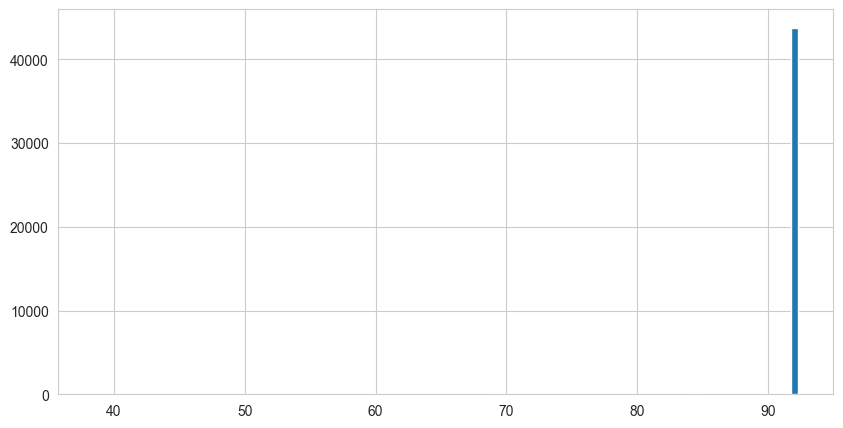

In [72]:
# How many null values are there per row?
# And how do these null values correlate with sepsis? First, let's look at the null values per row.
# Maybe there is a clear pattern, e.g. all rows with sepsis == 1 have a lot of null values or vice versa.

# Count number of null values per row
null_counts = variables.isnull().sum(axis=1)
# Divide by number of columns to get percentage of null values per row
null_counts = (null_counts / variables.shape[1]) * 100

# Plot histogram of null values per row
null_counts.hist(bins=100, figsize=(10, 5))

# Add null_counts as new column to df
variables["null_counts"] = null_counts

# Print average percentage of null values per row, split by sepsis
# (Should roughly equal 33% for sepsis==1 and 30% for sepsis==0)
print("Average percentage of null values per row where sepsis == 1: ", variables[variables["sepsis"] == 1]["null_counts"].mean())
print("Average percentage of null values per row where sepsis == 0: ", variables[variables["sepsis"] == 0]["null_counts"].mean())

# Drop null_counts column again
if "null_counts" in variables.columns:
    variables.drop("null_counts", axis=1, inplace=True)

# Coarse grained view is inconclusive, let's look at a finer grained view...

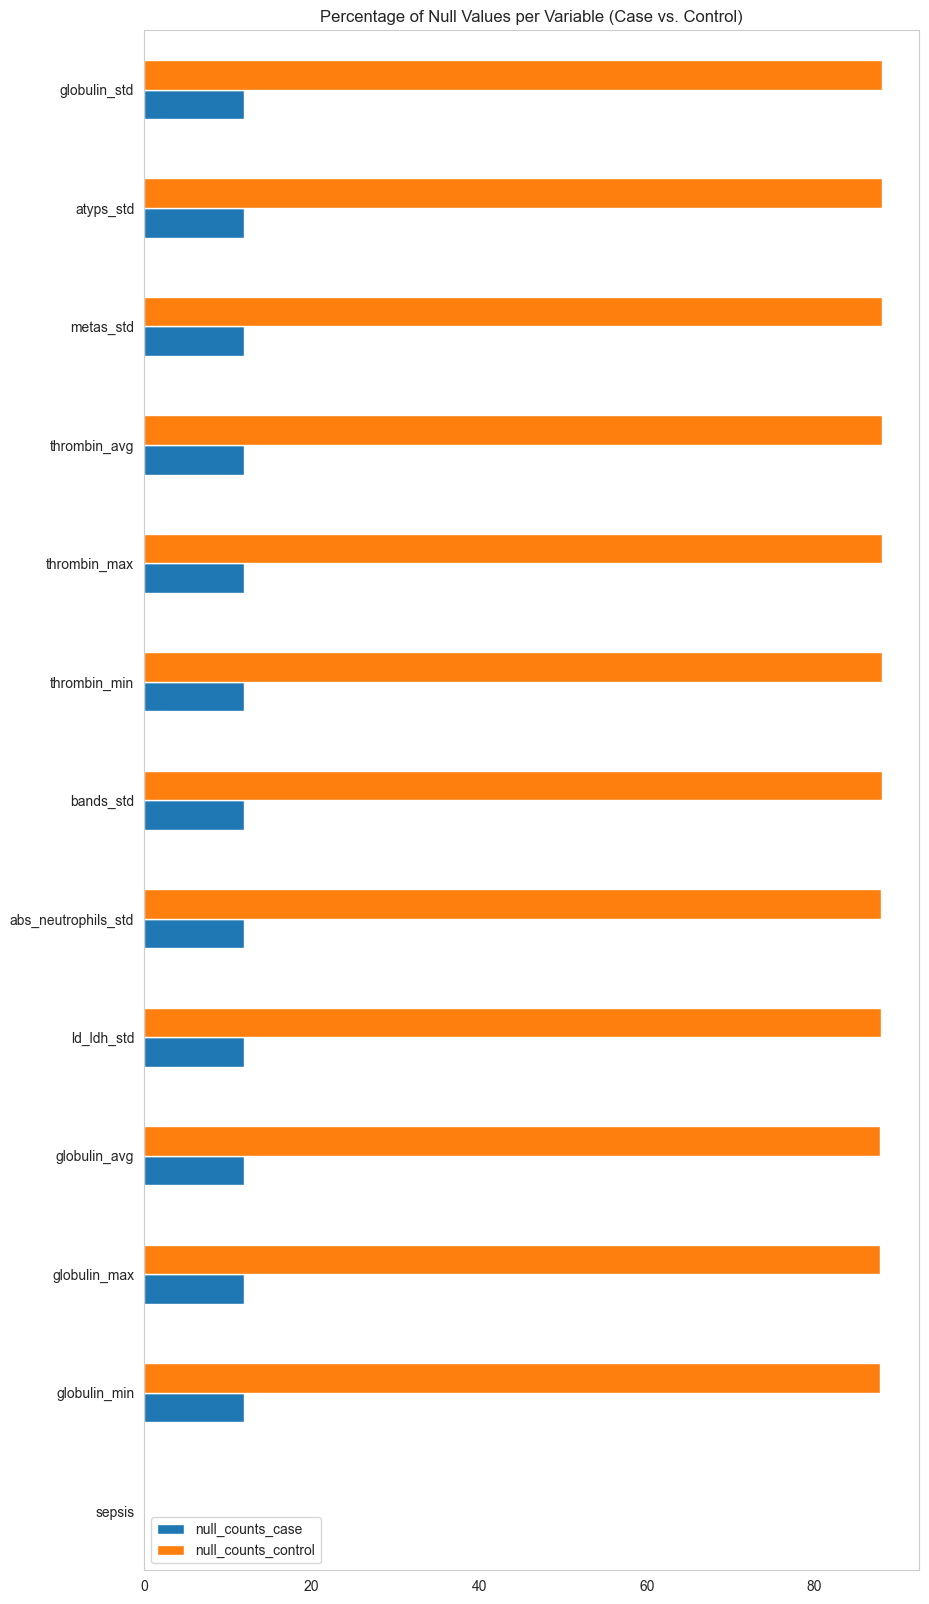

In [73]:
# What about the distribution of null values per column, i.e. the distribution of null values for each variable?
# Maybe the average number of null values per row is roughly the same, but the distribution of null values per column could be different.
# This could mean that the model would still be able to learn a shortcut, e.g. "if variable x is null, then sepsis == 1".

# Count number of null values per column, i.e. per variable
null_counts_sepsis = variables[variables["sepsis"] == 1].isnull().sum(axis=0).to_frame(name="null_counts")
null_counts_sepsis_not = variables[variables["sepsis"] == 0].isnull().sum(axis=0).to_frame(name="null_counts")

# Divide by number of rows to get percentage of null values per column, i.e. per variable
# (We use the number of overall rows to obtain the percentage of null values per column, not the number of rows where sepsis == 1 or sepsis == 0)
null_counts_sepsis = (null_counts_sepsis / variables.shape[0]) * 100
null_counts_sepsis_not = (null_counts_sepsis_not / variables.shape[0]) * 100

# Join null_counts_sepsis and null_counts_sepsis_not to plot them in one plot
null_counts_sepsis = null_counts_sepsis.join(null_counts_sepsis_not, lsuffix="_case", rsuffix="_control")

# Plot bar chart of null values per column, sort by difference in null values
null_counts_sepsis["diff"] = abs(null_counts_sepsis["null_counts_case"] - null_counts_sepsis["null_counts_control"])

# Do not display difference in bar chart, but sort by difference
null_counts_sepsis.sort_values(by="diff", ascending=True).drop("diff", axis=1).plot.barh(figsize=(10, 20), title="Percentage of Null Values per Variable (Case vs. Control)")

# save plot as pdf
plt.savefig("null_values_per_variable.pdf", bbox_inches="tight")

# Indeed, there are some variables where the difference in null values is quite large.
# For example, patients that develop a sepsis have a lot more null values for the variable "abs_neutrophils_avg" than patients that do not develop a sepsis.
# Let's try to calculate the correlation between the presence of a variable and the sepsis target.

<Axes: title={'center': 'Correlation of (presence encoded) variables with sepsis'}>

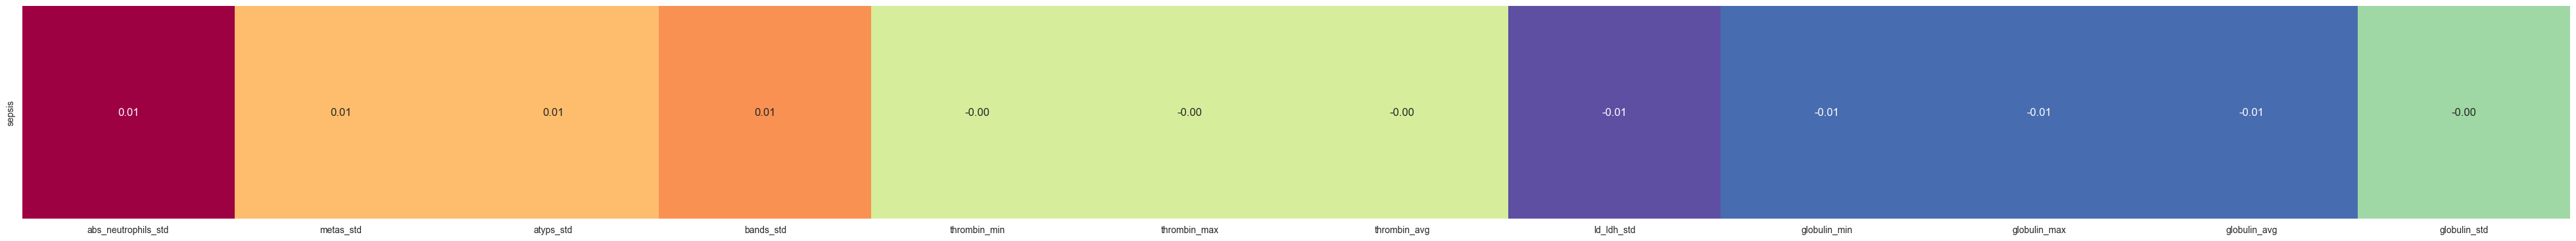

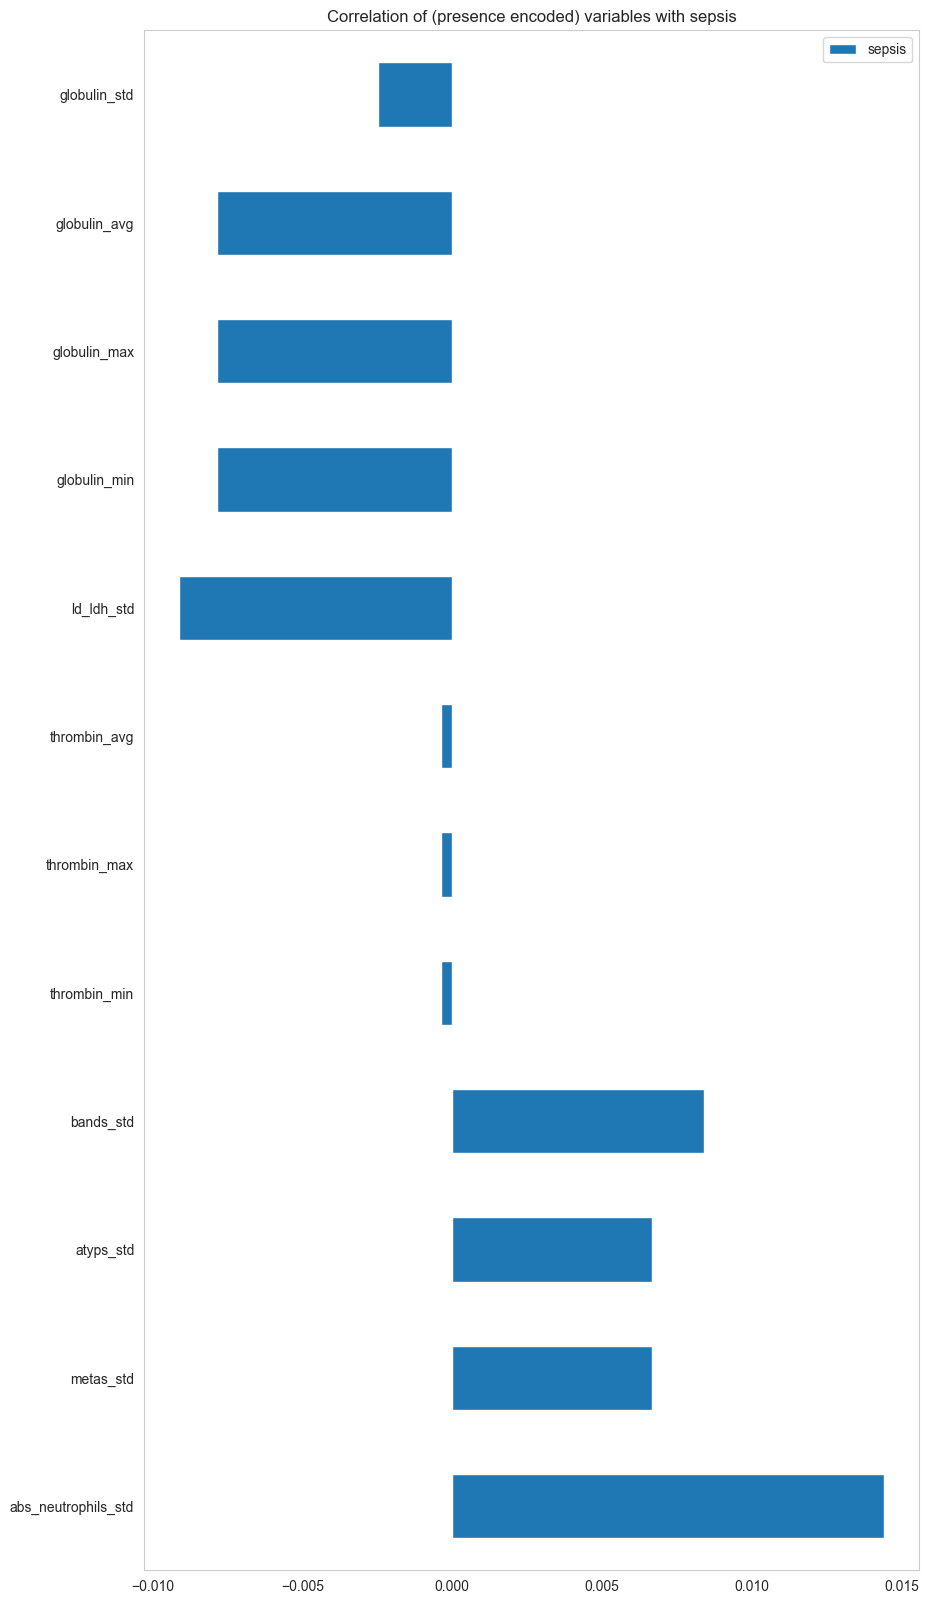

In [74]:
# To plot the correlation matrix, we need to replace the null values with some other value to encode the absence of a variable.
# Likewise, we need to replace all values != 0 with some other value to encode the presence of a variable.
# Let's use 0 for the absence of a variable and 1 for the presence of a variable.

# Split off the sepsis (target) column
sepsis = variables["sepsis"]

# Presence encode the feature set, i.e. replace all NaN values with 0 and all values != NaN with 1
present = variables.notna().astype(int)

# Replace the sepsis column with the original
present["sepsis"] = sepsis

# Compute the correlation matrix
corr = present.corr(method="pearson")

# The correlation matrix is a bit hard to read, let's extract only the correlations with the sepsis target.
# Drop all columns except the sepsis column
corr = corr.drop([col for col in corr.columns if col != "sepsis"])

# Drop sepsis entry from that column
corr = corr.drop(["sepsis"], axis=1)

# Let's plot only the correlations with the sepsis target.
# Still as a heatmap, because it's easier to see the correlations.
plt.subplots(figsize=(50, 5))
sns.heatmap(corr, annot=True, annot_kws={"size": 12}, cbar=False, cmap="Spectral_r", fmt=".2f", square=True)

# Let's plot the correlations with the sepsis target as a bar chart.
corr.T.plot.barh(figsize=(10, 20), title="Correlation of (presence encoded) variables with sepsis")

# This indicates that the simple presence of a variable is apparently a good indicator. This can be good or bad...
# It could mean that the model is able to learn a shortcut, e.g. "if variable x is present, then sepsis == 1".
# Or it could mean that the model is able to learn a causal relationship, e.g. some measurements are done less frequently for certain patients due to reasons we don't know.
# For example, maybe the variable "abs_neutrophils_avg" is only measured for patients that are already suspected to have a sepsis. (Although this is just a guess...)
# It is more likely that the model is able to learn a shortcut, because the correlations are quite high. 

# Note that negative correlations mean that the presence of a variable is negatively correlated with the sepsis target, i.e. the absence of a variable is positively correlated with the sepsis target.
# I.e. the absence of a variable is a good indicator for sepsis.
# Likewise, positive correlations mean that the presence of a variable is positively correlated with the sepsis target, i.e. the presence of a variable is a good indicator for sepsis.

In [75]:
# Based on the above, let's try to train a model simply using the presence of a variable as a feature.
# Let's use a gradient boosting classifier using the XGBoost library.

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import PredefinedSplit

# Convert types to float64
present = present.astype("float64")
# Split into features and target
X, y = present.drop("sepsis", axis=1), present["sepsis"]

# Split into train and test set
# Use 20% of the data for testing, use a fixed random state to make results reproducible
# Use stratify=y to ensure that the train and test set have the same ratio of sepsis==1 and sepsis==0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

# Print the number of rows in each set and the number of sepsis cases
print(f"Train set: {X_train.shape[0]} rows (ICU stays), {y_train.sum()} sepsis cases")
print(f"Test set: {X_test.shape[0]} rows (ICU stays), {y_test.sum()} sepsis cases")

# Create a validation set from the training data (10% of the training data)
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=RANDOM_SEED, stratify=y_train
)

# Combine the new train and validation sets
X_combined = np.concatenate((X_train_new, X_val), axis=0)
y_combined = np.concatenate((y_train_new, y_val), axis=0)

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [
    -1 if x in range(X_train_new.shape[0]) else 0 for x in range(X_combined.shape[0])
]

# Create the split for cross-validation
pds = PredefinedSplit(test_fold=split_index)

# Compute the ratio of sepsis==0 to sepsis==1 in the training set
# This is used to set the scale_pos_weight hyperparameter
ratio = np.sum(y_train == 0) / np.sum(y_train == 1)

# Grid search for hyperparameter tuning
param_grid = {
    "max_depth": [5, 6, 7, 8, 9, 10],  # Maximum depth of a tree
    "learning_rate": [0.2, 0.1, 0.01],  # Learning rate
    "subsample": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],  # Subsample ratio of the training instances (randomly select a subset of the training data)
    "scale_pos_weight": [ratio, ratio * 2, ratio * 0.5]
}

# Create a classifier using the binary:logistic objective and the gpu_hist tree method
xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method="gpu_hist")

# Use grid search to find the best hyperparameters, use fixed split, use MCC as scoring metric
# Use verbose=5 to display progress, use n_jobs=-1 to use all available CPU cores
grid_search = GridSearchCV(xgb_model, param_grid, cv=pds, scoring='matthews_corrcoef', verbose=5, n_jobs=10)
grid_search.fit(X_train, y_train)

print("Best params: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Train set: 35256 rows (ICU stays), 4200.0 sepsis cases
Test set: 8815 rows (ICU stays), 1050.0 sepsis cases
Fitting 1 folds for each of 378 candidates, totalling 378 fits
[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=7.394285714285714, subsample=0.3;, score=nan total time=   0.1s
[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=7.394285714285714, subsample=0.4;, score=nan total time=   0.1s
[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=7.394285714285714, subsample=0.6;, score=nan total time=   0.1s
[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=7.394285714285714, subsample=0.7;, score=nan total time=   0.0s[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=7.394285714285714, subsample=0.5;, score=nan total time=   0.1s

[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=14.788571428571428, subsample=0.6;, score=nan total time=   0.0s
[CV 1/1] END learning_rate=0.2, max_depth=5, scale_pos_weight=7.39428571

ValueError: 
All the 378 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013b4e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013b5cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000013b5c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000013b5e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000013b5e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000013b4ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105bd4860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001324e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001325cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001325c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001325e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001325e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001324ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a1c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001217a19f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121887248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001218823a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001218a21e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001218a24f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001217bb248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104448860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126de59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126ecb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000126ec63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000126ee61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000126ee64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000126dff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010766c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001250e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001251cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001251c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001251e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001251e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001250ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104fbc860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011eda59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000011ee8b248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000011ee863a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000011eea61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000011eea64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000011edbf248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000101914860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012284d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000122933248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000012292e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000012294e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000012294e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000122867248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001033ac860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001222e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001223cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001223c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001223e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001223e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001222ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106034860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001246e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001247cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001247c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001247e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001247e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001246ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010721c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:54] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000121d4d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121e33248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000121e2e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000121e4e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000121e4e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000121d67248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a0c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:55] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001217a19f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121887248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001218823a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001218a21e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001218a24f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001217bb248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104448860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:55] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001250e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001251cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001251c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001251e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001251e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001250ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104fbc860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:55] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011eda59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000011ee8b248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000011ee863a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000011eea61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000011eea64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000011edbf248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000101914860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:55] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001324e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001325cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001325c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001325e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001325e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001324ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a1c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:55] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000121d4d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000121e33248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000121e2e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000121e4e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000121e4e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000121d67248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000104a0c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:55] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013b4e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013b5cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000013b5c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000013b5e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000013b5e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000013b4ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000105bd4860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:55] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000126de59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000126ecb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x0000000126ec63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x0000000126ee61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x0000000126ee64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000126dff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010766c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:55] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001222e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001223cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001223c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001223e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001223e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001222ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x0000000106034860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:55] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001246e59f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001247cb248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x00000001247c63a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x00000001247e61e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x00000001247e64f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x00000001246ff248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x000000010721c860 _ctypes_callproc + 788



--------------------------------------------------------------------------------
22 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
                    ^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [11:15:55] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012284d9f8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000122933248 xgboost::gbm::GBTree::ConfigureUpdaters() + 476
  [bt] (2) 3   libxgboost.dylib                    0x000000012292e3a0 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 952
  [bt] (3) 4   libxgboost.dylib                    0x000000012294e1e0 xgboost::LearnerConfiguration::Configure() + 1124
  [bt] (4) 5   libxgboost.dylib                    0x000000012294e4f8 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000122867248 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001add6f050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001add77b04 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-311-darwin.so       0x00000001033ac860 _ctypes_callproc + 788




In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC

# Initializing models
models = {
    "RandomForestClassifier": RandomForestClassifier(random_state=RANDOM_SEED),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "LogisticRegression": LogisticRegression(random_state=RANDOM_SEED, max_iter=1000),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=RANDOM_SEED),
    "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=RANDOM_SEED),
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier(random_state=RANDOM_SEED),
    "GaussianNB": GaussianNB(),
    "SupportVectorClassifier": SVC(random_state=RANDOM_SEED),
    #"XGBoost": xgb.XGBClassifier(random_state=RANDOM_SEED, objective="binary:logistic", tree_method="gpu_hist", **grid_search.best_params_)
}

# Fit all models
for model_name, model in models.items():
        model.fit(X_train, y_train)

In [78]:
# To evaludate the models, we need to predict the test data
# Apparently, the version of scikit-learn used leads to the kernel dying when predicting the test data multiple times in a row
# Therefore, to not have to restart the kernel every time, we save the predictions to a variable here and work with that
predictions = {}

for model_name, model in models.items():
    predictions[model_name] = model.predict(X_test)

In [79]:
from sklearn.metrics import matthews_corrcoef, roc_auc_score, f1_score
import pandas as pd

# Initialize an empty list to hold the score data
scores = []

# Calculate MCC, F1, and ROC AUC for each model, and store the values in the list
for model_name, y_pred in predictions.items():
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    scores.append({"Model": model_name, "MCC": mcc, "F1": f1, "ROC AUC": roc_auc})

# Convert the list of scores to a DataFrame
score_df = pd.DataFrame(scores)

# Sort models based on MCC and select top n models
top_n = 5  # Change this to select a different number of models
metric = "MCC"
top_models = score_df.nlargest(top_n, metric)

# Print the chosen models
print(f"Top {top_n} models according to {metric}:")
for index, row in top_models.iterrows():
    print(f"{row['Model']} MCC={row[metric]:.3f}")

Top 5 models according to MCC:
GaussianNB MCC=0.017
LogisticRegression MCC=0.000
HistGradientBoostingClassifier MCC=0.000
RandomForestClassifier MCC=-0.004
DecisionTreeClassifier MCC=-0.004


In [80]:
from sklearn.ensemble import VotingClassifier

# Get the top model objects for the voting classifier
top_model_objects = [(row['Model'], models[row['Model']].__class__(**models[row['Model']].get_params())) for _, row in top_models.iterrows()]

# Create and fit a voting classifier with the top models
voting_classifier = VotingClassifier(estimators=top_model_objects, voting="hard")
voting_classifier.fit(X_train, y_train)

# Get the predictions of the voting classifier
y_pred = voting_classifier.predict(X_test)

# Create a DataFrame with the results of the voting classifier
voting_results = pd.DataFrame([{
    "Model": "VotingClassifier",
    "MCC": matthews_corrcoef(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_pred)
}])

# Delete row with VotingClassifier if it already exists
if score_df[score_df['Model'] == 'VotingClassifier'].index.any():
    score_df = score_df.drop(score_df[score_df['Model'] == 'VotingClassifier'].index)
    
# Concat the results to the bottom of the score dataframe
score_df = pd.concat([score_df, voting_results], ignore_index=True)

# Display the score dataframe
score_df

,Model,MCC,F1,ROC AUC
0,RandomForestClassifier,-0.003917,0.000000,0.499936
1,DecisionTreeClassifier,-0.003917,0.000000,0.499936
2,LogisticRegression,0.000000,0.000000,0.500000
3,GradientBoostingClassifier,-0.003917,0.000000,0.499936
4,ExtraTreesClassifier,-0.003917,0.000000,0.499936
5,HistGradientBoostingClassifier,0.000000,0.000000,0.500000
6,GaussianNB,0.016807,0.213385,0.501584
7,SupportVectorClassifier,-0.003917,0.000000,0.499936
8,VotingClassifier,-0.003917,0.000000,0.499936


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

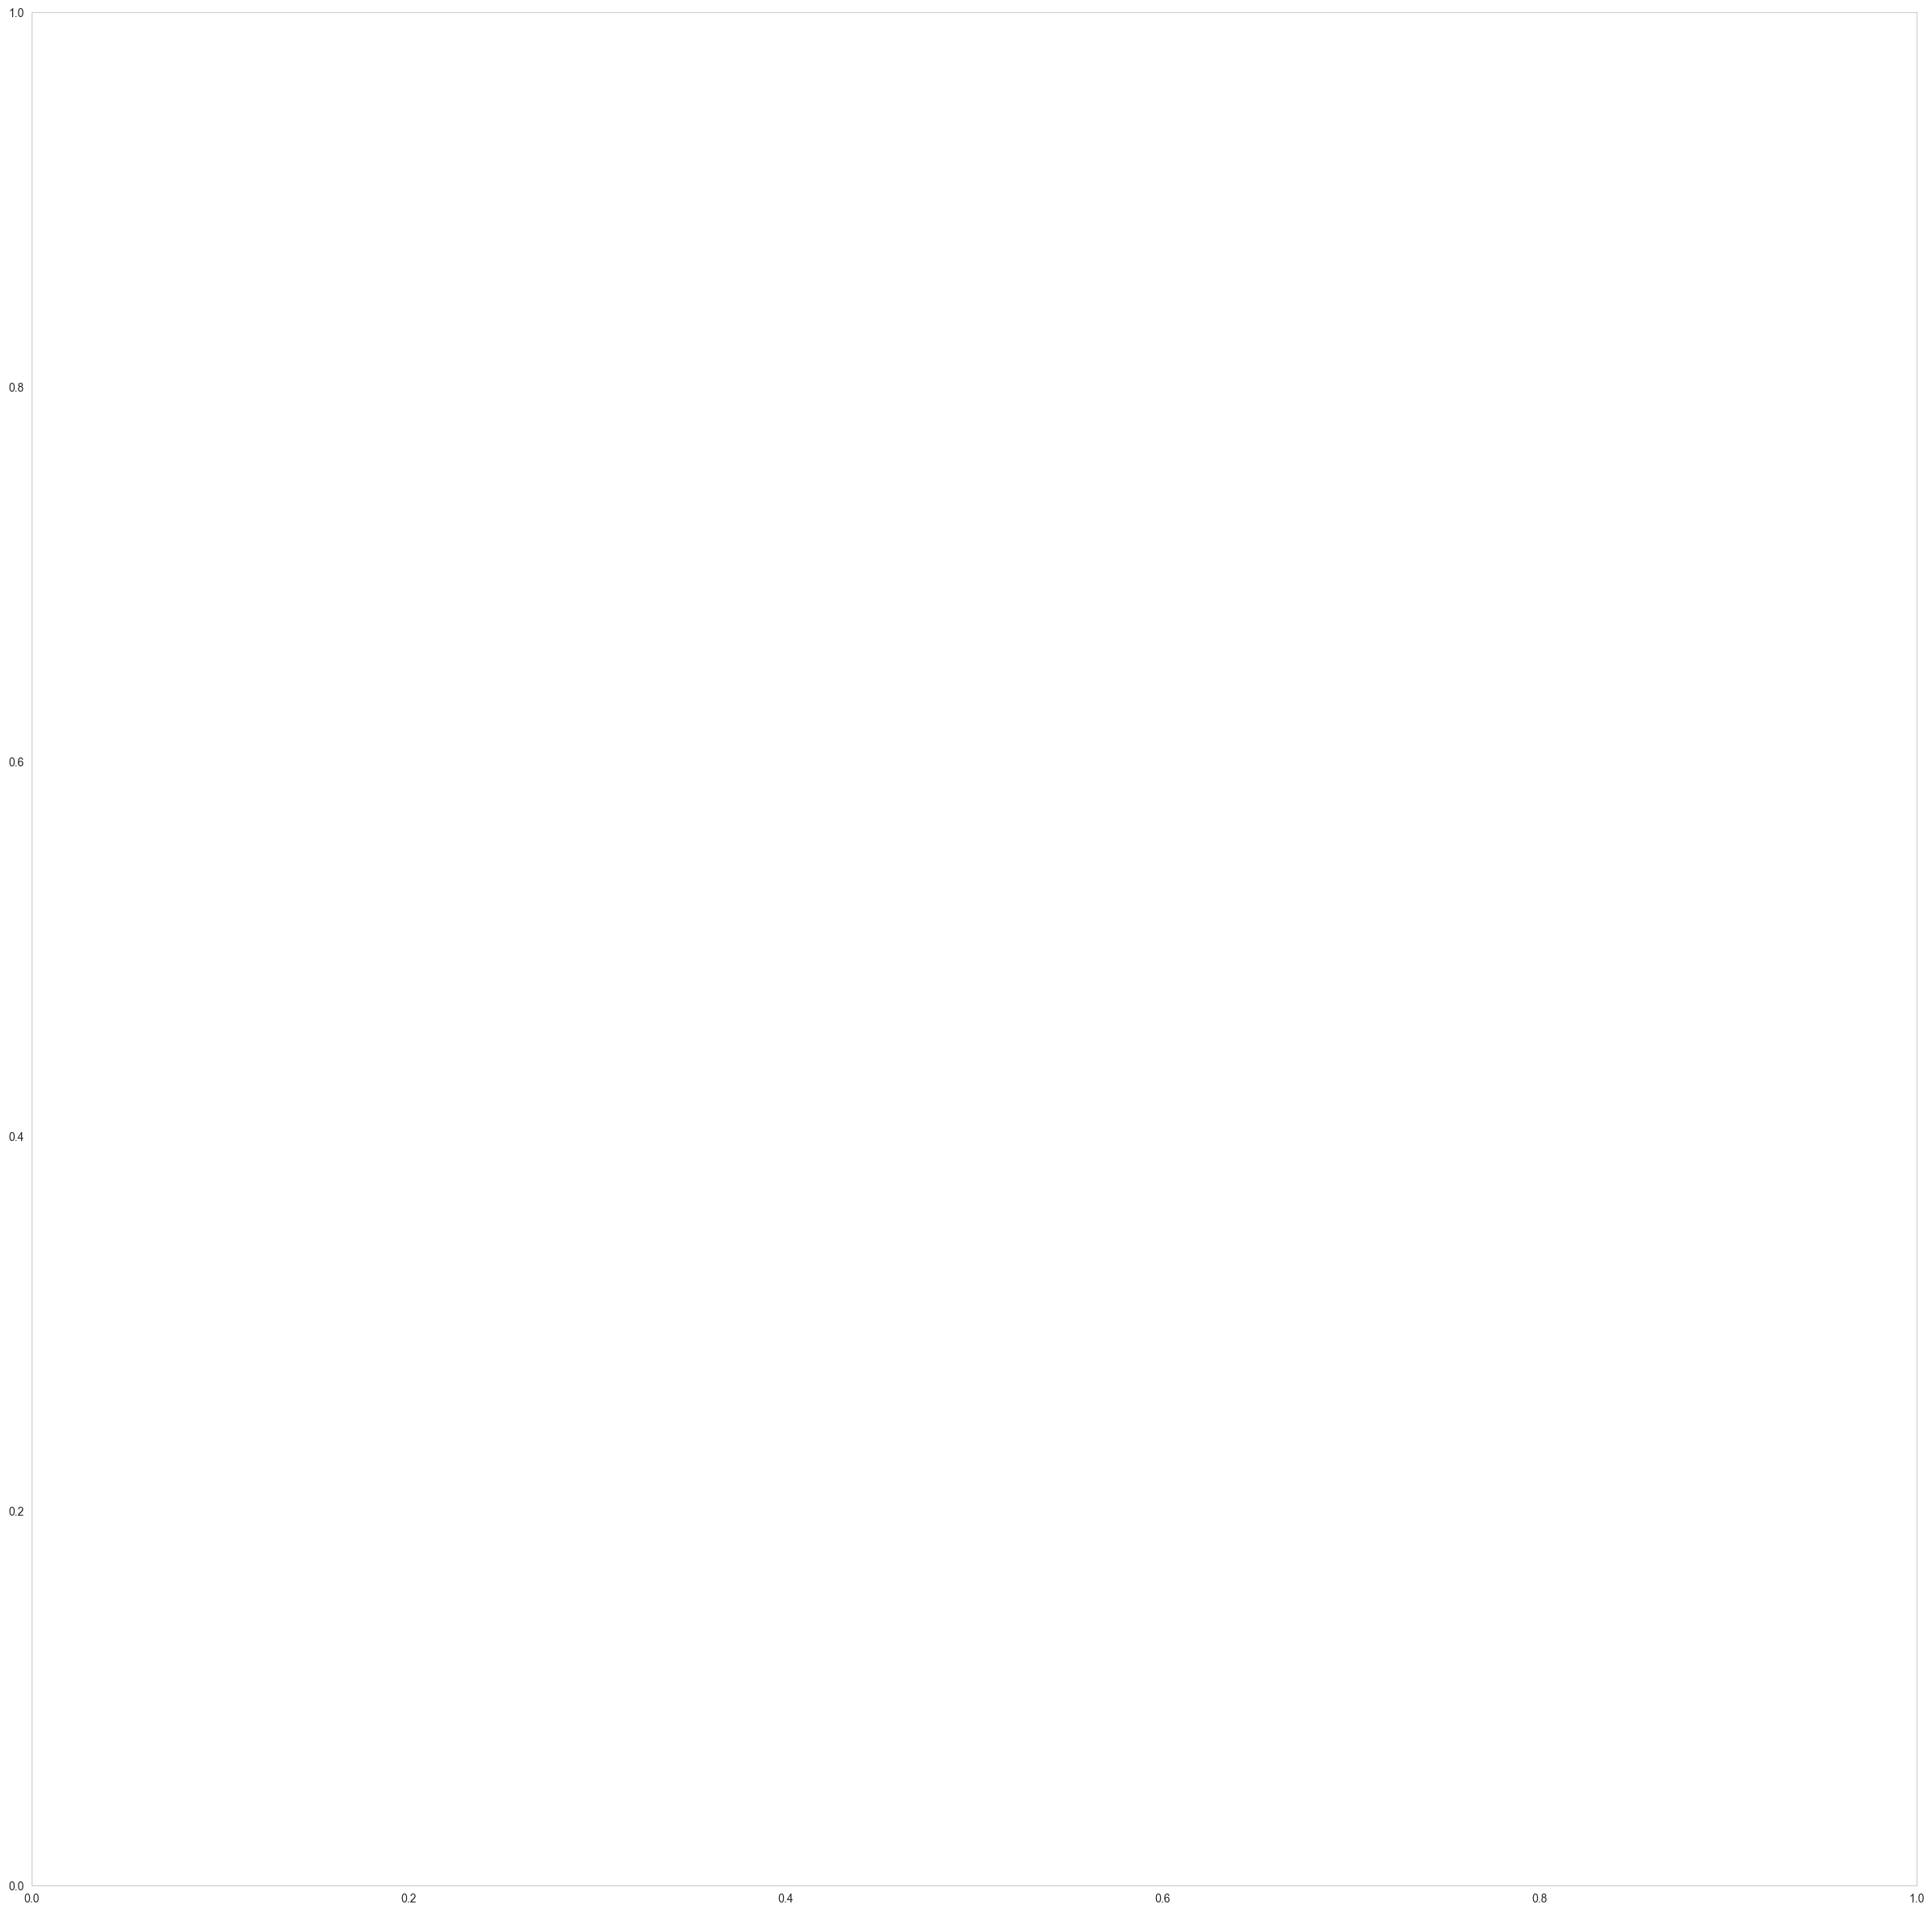

In [81]:
# Let's take a look at the learned tree.
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(grid_search.best_estimator_, ax=ax, rankdir="LR")
plt.show()

c:\Users\Claas\Repos\kp2\kp-medizinische-informatik-ss23\.venv\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Claas\Repos\kp2\kp-medizinische-informatik-ss23\.venv\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-

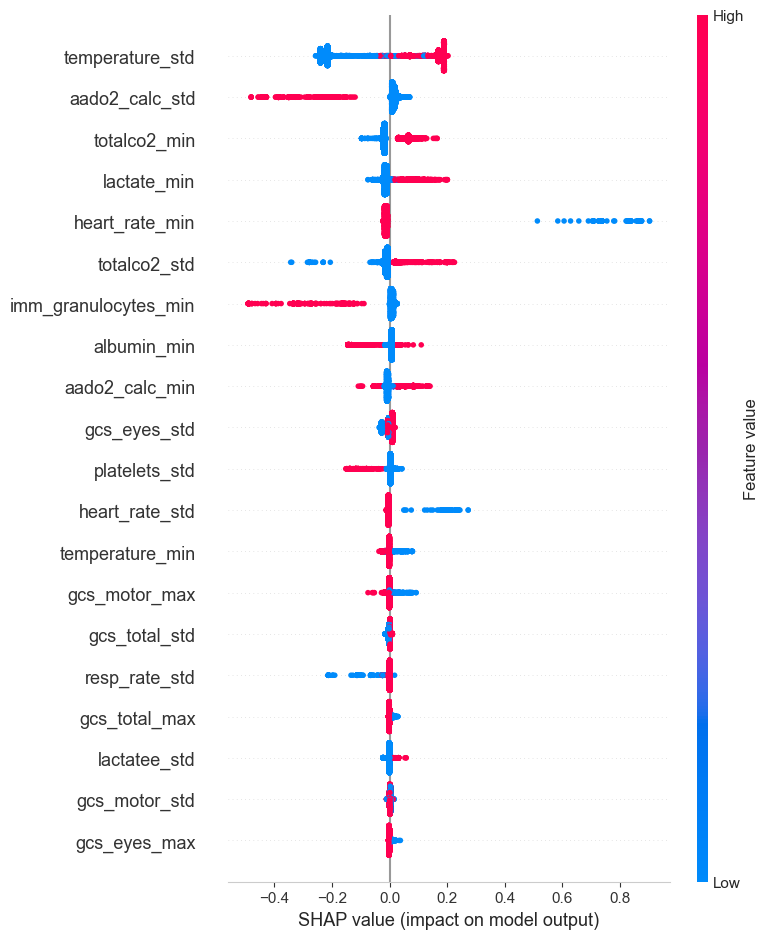

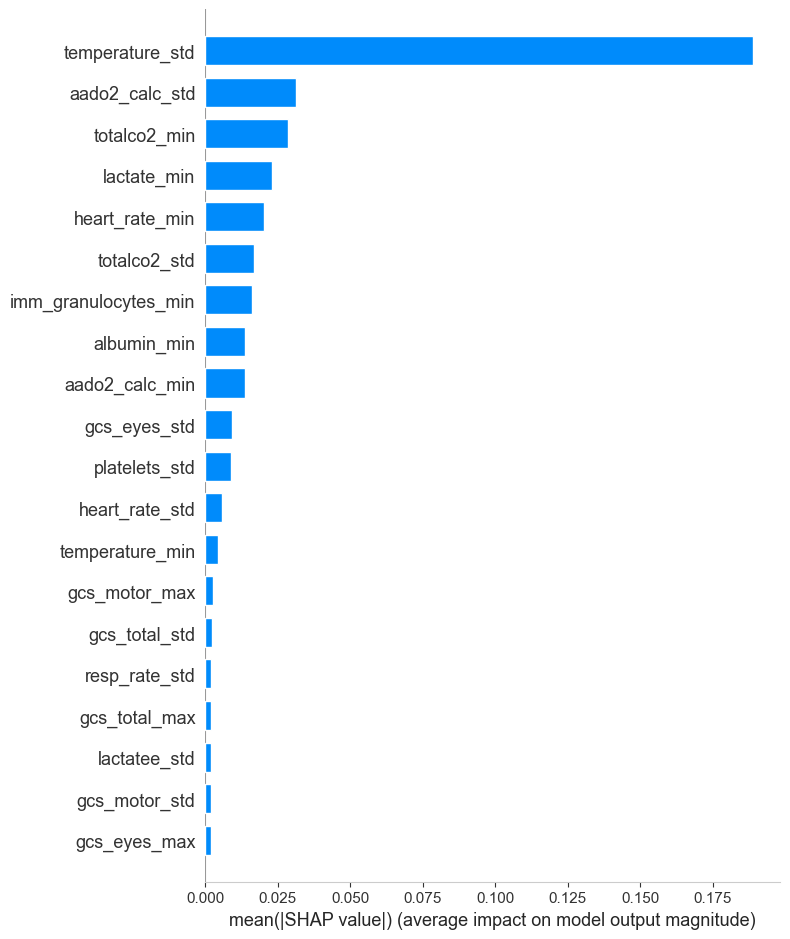

In [ ]:
# XGBoost provides some built-in functions to plot feature importance
# We'll ignore those for now and use the shap library instead, anyway here's how to use the built-in functions:
# Gain: Improvement in accuracy resulting from a split according to this feature
# xgb.plot_importance(model, importance_type="gain", show_values=True, max_num_features=20)
# Weight: Number of times this feature occurs in the trees
# xgb.plot_importance(model, importance_type="weight", show_values=True, max_num_features=20)
# Cover: Number of times this feature occurs in the trees weighted by the number of training data points
# xgb.plot_importance(model, importance_type="cover", show_values=True, max_num_features=20)

# Let's look at the feature importance for the best estimator found by grid search (shap values)
import shap
# Initialize javascript visualization
shap.initjs()

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Create a TreeExplainer object using the best estimator
model = grid_search.best_estimator_
explainer = shap.TreeExplainer(model)
# Calculate shap values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the shap values for the test set, only show the 20 most important features
shap.summary_plot(shap_values, X_test, max_display=20)
# Plot the shap values for the test set as a bar chart, only show the 20 most important features
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)
# Some quick notes on interpretability:
# Color encodes the feature value, red means high feature value (aka 1, variable present), blue means low feature value (aka 0, variable absent)
# The x-axis encodes the impact on the model output, i.e. the prediction, left means negative impact, right means positive impact